In [1]:
import os
import importlib
import re
import analyse
import numpy as np
import Bio.PDB as biop
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.helanal as helanal
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# importlib.reload(analyse)

In [16]:
def save_figure(fig, target):
    fig.savefig(target)

In [43]:
PDB_CODE = '4djh'
SEQ = 'A'
folder = '../'+PDB_CODE+SEQ+'/'
plot_folder = folder+'plots/'
# it should be the folder which contains all the initial parameters and the simultaion results
# name should be 'charmm-gui-'+folder pl: charmm-gui-6b73B
# later this folder should be copied from cluster containig the NAMD results

results_folder = folder+'results/'

In [45]:
trajectories = []
dcd_files = sorted([results_folder+'namd/'+i for i in os.listdir(results_folder+'namd/') if re.match(r'(step6.).*\_equilibration.dcd$', i)])
for i in range(6):
    u = mda.Universe(results_folder+'/step5_assembly.xplor_ext.psf', dcd_files[i])
    trajectories.append(u)

## Root mean square deviation:

Text(0.5,0,'Equilibration step')

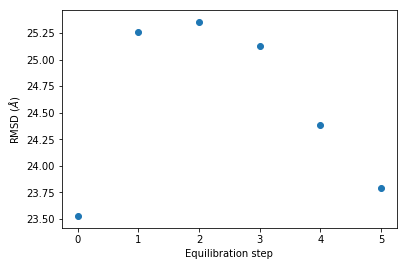

In [46]:
rmsds = []
for i in range(len(trajectories)):
    first_frame = trajectories[i].select_atoms('name CA').positions[0]
    last_frame = trajectories[i].select_atoms('name CA').positions[-1]
    rmsds.append(rms.rmsd(last_frame, first_frame))

plt.scatter(range(len(trajectories)), rmsds)
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('Equilibration step')

### RMSD of backbone over time:

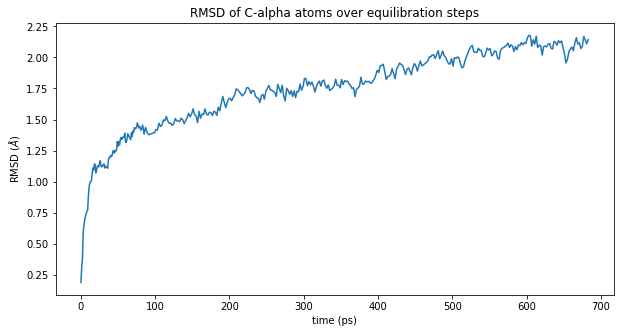

In [48]:
all_traj = mda.Universe(results_folder+'/step5_assembly.xplor_ext.psf', dcd_files)    
ref = mda.Universe(folder+PDB_CODE+'_inp.pdb')
title = 'RMSD of C-alpha atoms over equilibration steps'
R, r_fig = analyse.rmsd_traj(all_traj, ref, title)

In [49]:
save_figure(r_fig[0].figure, plot_folder+'eq_rmsd')

## Root mean square fluctuation:

In [50]:
struct = analyse.secondary_structure(folder+PDB_CODE+'_inp.pdb')

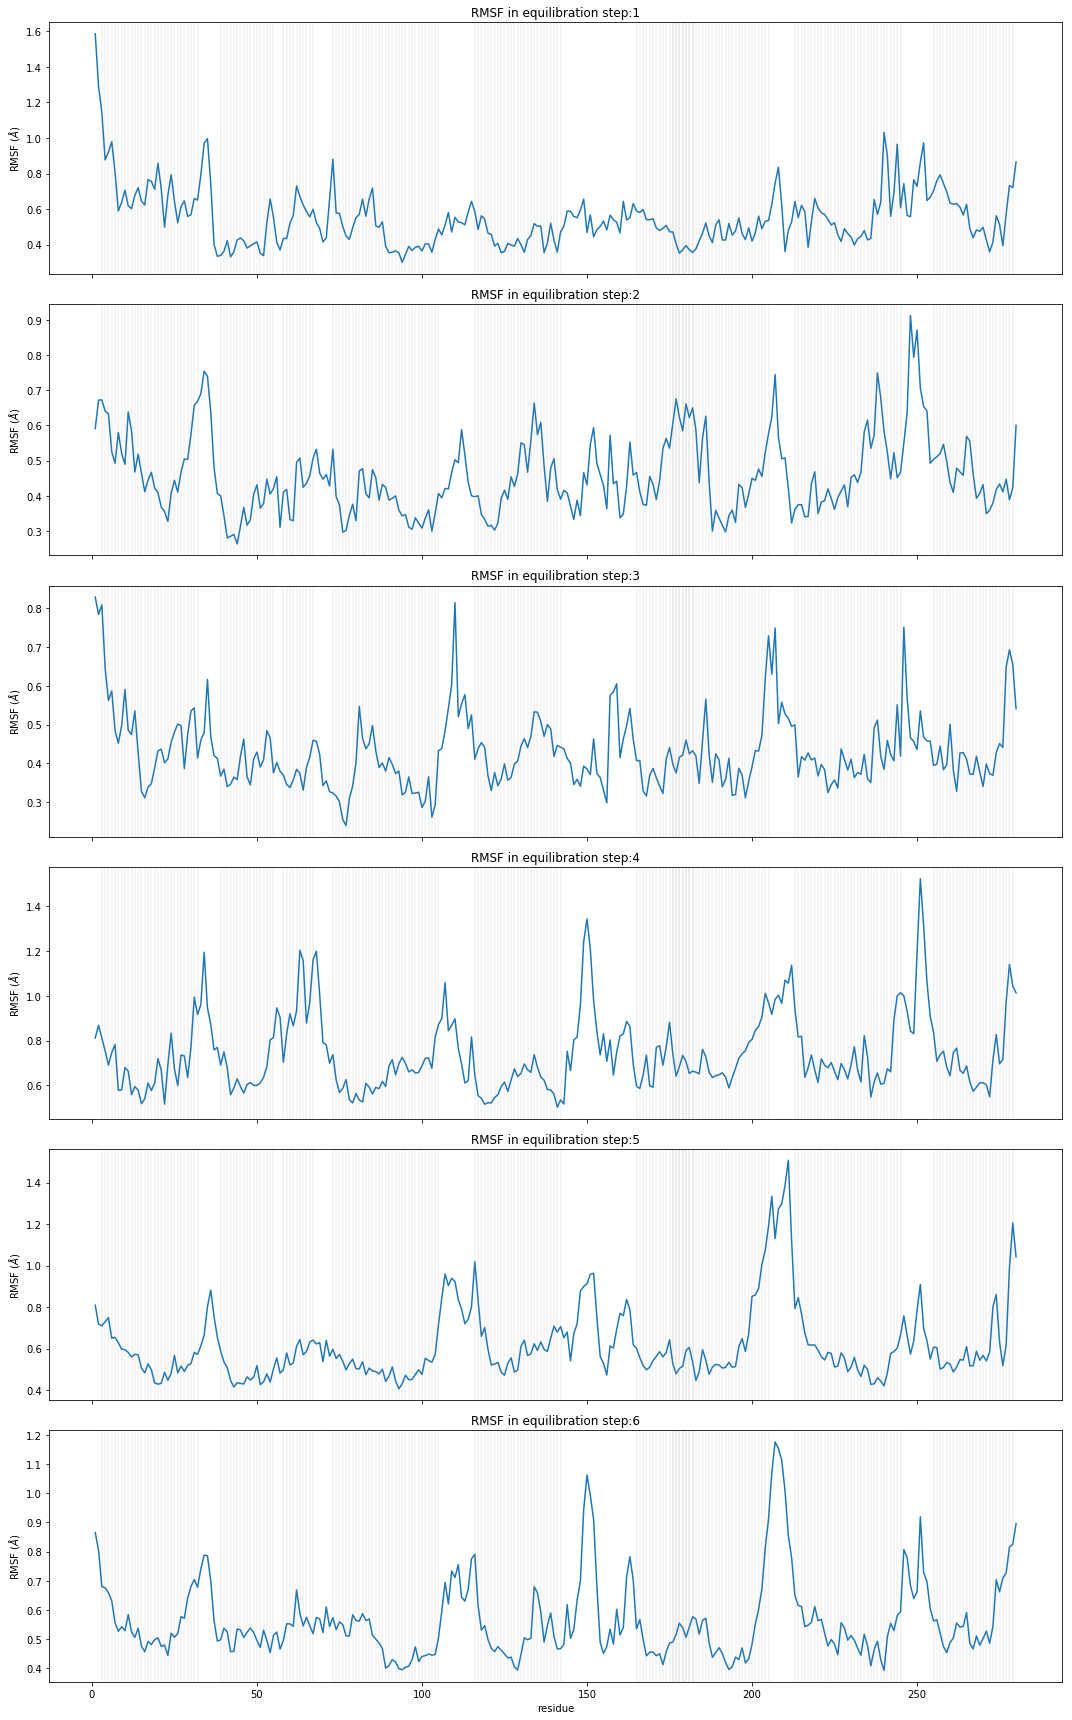

In [51]:
rf_fig = analyse.rmsf_plot(trajectories, title='RMSF in equilibration step:{}', structure=struct)

In [52]:
save_figure(rf_fig, plot_folder+'eq_rmsf_steps')

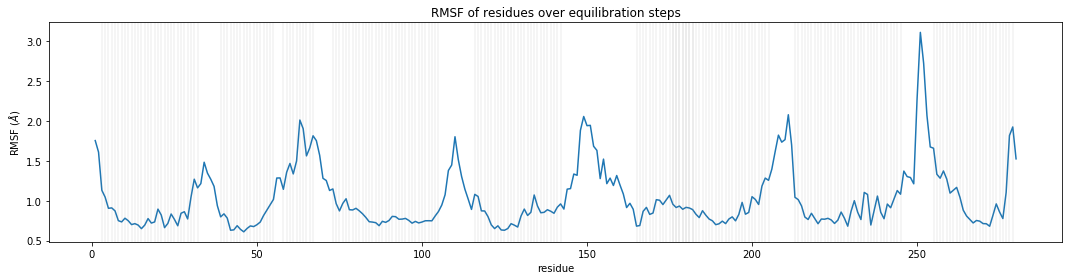

In [53]:
rmsf_fig = analyse.rmsf_plot([all_traj], title='RMSF of residues over equilibration steps', structure=struct)

In [54]:
save_figure(rmsf_fig, plot_folder+'eq_rmsf')